In [1]:
import astropy
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from matplotlib.colors import LogNorm

In [2]:
data_file = '../data/filtered_high_quality_sample.fits'

with fits.open(data_file) as hdul:
    # Access the first table extension
    data = hdul[1].data
    
    # Convert to DataFrame
    df = pd.DataFrame({col.name: data[col.name].byteswap().newbyteorder() if data[col.name].dtype.byteorder == '>' else data[col.name] for col in data.columns})


pd.set_option('display.max_columns', None)

df.head()

,source_id,l,b,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ruwe,radial_velocity,radial_velocity_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,catwise_w1,catwise_w2,mh_xgboost,teff_xgboost,logg_xgboost,in_training_sample,col1,col2,Source,RA_ICRS,DE_ICRS,rgeo,b_rgeo_x,B_rgeo_xa,rpgeo,b_rpgeo_x,B_rpgeo_xa,Flag,angDist,fpu,E(B-V),distance_kpc,R,Z
0,15741055975040,176.739184,-48.572035,45.136038,0.335043,1.439792,0.018947,-0.711280,0.017718,-1.412098,0.016528,1.036041,-0.738894,0.316921,10.254021,10.750235,9.595748,8.152,8.198,-0.144,5065.8,2.993,True,45.136038,0.335043,15741055975040,45.136038,0.335043,695.683899,683.627625,707.396423,696.278320,688.270874,707.143982,10033,0.0,0.013160,0.104689,696.278320,8.582006,-0.522061
1,66627828480768,176.483565,-48.171322,45.305053,0.736093,0.534038,0.020692,3.309832,0.022959,1.594356,0.022822,1.349013,41.607450,1.323430,10.508830,11.150953,9.741709,7.891,7.964,-0.401,4499.0,1.916,False,45.305053,0.736093,66627828480768,45.305053,0.736093,1884.275020,1821.247560,1947.302730,1883.143550,1807.318600,1944.665770,10033,0.0,0.038747,0.093026,1883.143550,9.375831,-1.403210
2,82467667849472,176.209301,-48.607026,44.866246,0.561503,2.209985,0.016049,-4.869755,0.015797,-12.678339,0.013950,1.018742,-32.461674,0.205614,10.651456,11.169626,9.980610,8.496,8.558,0.114,4938.3,3.203,True,44.866246,0.561503,82467667849472,44.866246,0.561503,452.636078,448.701294,456.615540,452.602692,449.257355,455.432892,10033,0.0,0.007262,0.086075,452.602692,8.420638,-0.339539
3,101193725229056,175.755174,-48.727781,44.569524,0.689953,0.528788,0.024241,3.539184,0.027864,-1.599436,0.021891,1.176748,91.295900,4.830661,14.332739,14.816101,13.685076,12.220,12.275,-0.478,4980.2,3.319,False,44.569524,0.689953,101193725229056,44.569524,0.689953,1908.478270,1815.024170,2014.483890,1868.603880,1800.940800,1949.831300,10033,0.0,0.045842,0.078062,1868.603880,9.351665,-1.404413
4,130399502833792,175.789759,-48.328584,44.868872,0.955080,0.847929,0.017479,3.382907,0.017619,-0.291235,0.015982,1.087555,1.959265,0.328298,11.215295,11.810178,10.481738,8.728,8.815,-0.159,4643.6,2.398,True,44.868872,0.955080,130399502833792,44.868872,0.955080,1178.407470,1155.319820,1203.711180,1177.687260,1154.219600,1201.322750,10033,0.0,0.020614,0.077163,1177.687260,8.903067,-0.879697


## Figure 1 - Left

In [3]:
df['distance_kpc'] = df['rpgeo']

# Replace infinite values caused by zero parallax with NaN
df['distance_kpc'] = df['distance_kpc'].replace([float('inf'), -float('inf')], pd.NA)


# Inspect the first few rows
print(df[['source_id', 'parallax', 'distance_kpc']].head())


         source_id  parallax  distance_kpc
0   15741055975040  1.439792    696.278320
1   66627828480768  0.534038   1883.143550
2   82467667849472  2.209985    452.602692
3  101193725229056  0.528788   1868.603880
4  130399502833792  0.847929   1177.687260


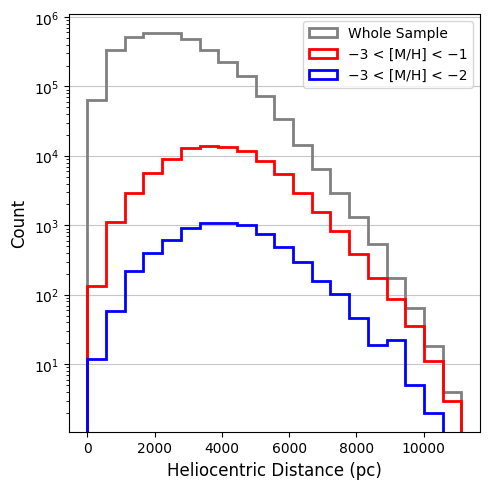

In [4]:
import numpy as np
import matplotlib.pyplot as plt

distance_col = 'distance_kpc'
mh_col = 'mh_xgboost'

# Define bin edges (20 bins from 0 to the maximum value in the distance column)
bin_edges = np.linspace(0, df[distance_col].max(), 21)

# Subset the data based on [M/H] ranges
subset_mh_neg1 = df[(df[mh_col] > -3) & (df[mh_col] < -1)]
subset_mh_neg2 = df[(df[mh_col] > -3) & (df[mh_col] < -2)]

# Plot the histogram for the whole sample
plt.figure(figsize=(5, 5))
plt.hist(
    df[distance_col],
    bins=bin_edges,  # Use defined bin edges
    histtype='step',
    color='grey',
    linewidth=2,
    label='Whole Sample'
)

# Plot the histogram for the subset with -3 < [M/H] < -1
plt.hist(
    subset_mh_neg1[distance_col],
    bins=bin_edges,  # Use defined bin edges
    histtype='step',
    color='red',
    linewidth=2,
    label='−3 < [M/H] < −1'
)

# Plot the histogram for the subset with -3 < [M/H] < -2
plt.hist(
    subset_mh_neg2[distance_col],
    bins=bin_edges,  # Use defined bin edges
    histtype='step',
    color='blue',
    linestyle='-',
    linewidth=2,
    label='−3 < [M/H] < −2'
)

# Set logarithmic scale for y-axis
plt.yscale('log')

# Add title and labels
plt.xlabel('Heliocentric Distance (pc)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='-', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig('../figures/distance_histogram.png', dpi=300)
plt.show()

# Figure 1 - Middle

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_galactocentric_manual(df):
    """
    Manually calculate Galactocentric coordinates (R and Z).

    Parameters:
    - df: DataFrame with necessary astrometric data.

    Returns:
    - DataFrame with added Galactocentric radius (R) and Z coordinates.
    """
    # Define constants
    R_sun = 8.122  # Distance of the Sun from the Galactic centre in kpc

    # Convert l and b from degrees to radians
    l_rad = np.radians(df['l'].values)
    b_rad = np.radians(df['b'].values)

    # Use rpgeo as distance in kpc
    d_kpc = df['rpgeo'].values / 1000  # Convert from pc to kpc

    # Calculate Cartesian coordinates
    x = d_kpc * np.cos(b_rad) * np.cos(l_rad)
    y = d_kpc * np.cos(b_rad) * np.sin(l_rad)
    z = d_kpc * np.sin(b_rad)

    # Adjust for Sun's position relative to the Galactic centre
    x_galactocentric = x - R_sun

    # Calculate cylindrical radius R
    R = np.sqrt(x_galactocentric**2 + y**2)

    # Add results to the DataFrame
    df['R'] = R  # Galactocentric radius in kpc
    df['Z'] = z  # Height above the Galactic plane in kpc

    return df

# Apply the function to your DataFrame
df = calculate_galactocentric_manual(df)

# Apply the metallicity cut for [M/H] between -3 and -1
df_filtered = df[(df['mh_xgboost'] > -3) & (df['mh_xgboost'] < -1)]

# Remove rows with NaN values in R or Z columns
df_clean = df_filtered.dropna(subset=['R', 'Z'])

# Check the number of NaN values removed (optional)
print(f"Rows with NaN values removed: {len(df_filtered) - len(df_clean)}")


Rows with NaN values removed: 1


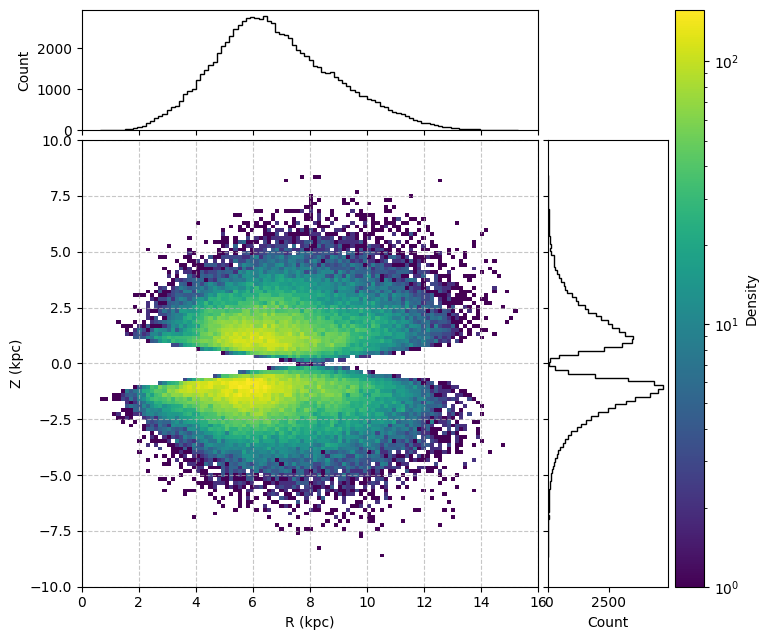

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_rz_distribution(df, r_column='R', z_column='Z', bins=100):
    """
    Plot Galactocentric radius (R) vs height (Z) distribution with 1D histograms on axes.
    
    Parameters:
    - df: DataFrame containing the data.
    - r_column: Name of the column for Galactocentric radius.
    - z_column: Name of the column for height above the Galactic plane.
    - bins: Number of bins for the histograms.
    """
    R = df[r_column]
    Z = df[z_column]

    # Define figure and grid
    fig, ax_scatter = plt.subplots(figsize=(8, 6.5))
    
    # Create divider for scatter plot and histograms
    divider = make_axes_locatable(ax_scatter)
    ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax_scatter)
    ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax_scatter)

    # Scatter plot with 2D histogram
    h = ax_scatter.hist2d(
        R, Z, bins=bins, norm=LogNorm(), cmap="viridis", cmin=1
    )
    cbar = fig.colorbar(h[3], ax=ax_scatter, pad=0.01)
    cbar.set_label("Density")
    
    ax_scatter.set_xlabel("R (kpc)")
    ax_scatter.set_ylabel("Z (kpc)")
    ax_scatter.set_xlim(0, 16)
    ax_scatter.set_ylim(-10, 10)
    ax_scatter.grid(True, linestyle="--", alpha=0.7)

    # 1D histograms
    ax_histx.hist(R, bins=bins, histtype="step", color="black")
    ax_histy.hist(Z, bins=bins, histtype="step", orientation="horizontal", color="black")

    # Remove ticks on histograms for cleaner appearance
    ax_histx.tick_params(labelbottom=False)
    ax_histy.tick_params(labelleft=False)
    
    ax_histx.set_ylabel("Count")
    ax_histy.set_xlabel("Count")

    # Final adjustments
    fig.tight_layout()
    plt.savefig('../figures/ZR_distribution.png', dpi=300)
    plt.show()

# Example usage
plot_rz_distribution(df_clean, r_column='R', z_column='Z', bins=100)


# Figure 1 - Right

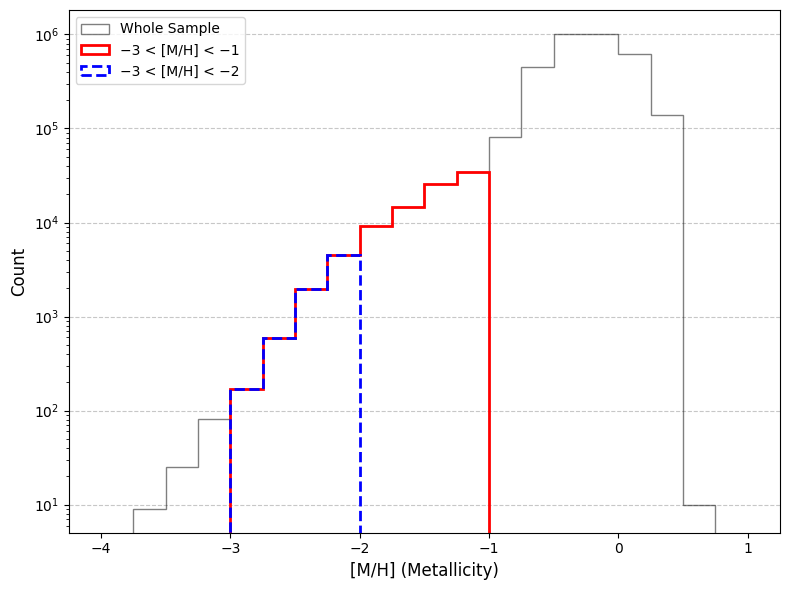

In [7]:
mh_col = 'mh_xgboost'

# Filter subsets of the data for specific metallicity ranges
subset_mh_neg1 = df[(df[mh_col] > -3) & (df[mh_col] < -1)]
subset_mh_neg2 = df[(df[mh_col] > -3) & (df[mh_col] < -2)]

# Define common bins from -4 to 1 with step size of 0.25
bins = np.arange(-4, 1 + 0.25, 0.25)  # Bins from -4 to 1 with 0.25 step size

# Plot the metallicity distribution
plt.figure(figsize=(8, 6))

# Whole sample
plt.hist(
    df[mh_col], bins=bins, color='grey', alpha=0.5, histtype='step', edgecolor='black',
    label='Whole Sample', density=False
)

# Subset with -3 < [M/H] < -1
plt.hist(
    subset_mh_neg1[mh_col], bins=bins, histtype='step', color='red', linestyle='-', linewidth=2,
    label='−3 < [M/H] < −1', density=False
)

# Subset with -3 < [M/H] < -2
plt.hist(
    subset_mh_neg2[mh_col], bins=bins, histtype='step', color='blue', linestyle='--', linewidth=2,
    label='−3 < [M/H] < −2', density=False
)

# Add labels, title, and legend
plt.xlabel('[M/H] (Metallicity)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Log scale for y-axis
plt.yscale('log')

# Show the plot
plt.tight_layout()
plt.savefig('../figures/metallicity_distribution.png', dpi=300)
plt.show()



# All together

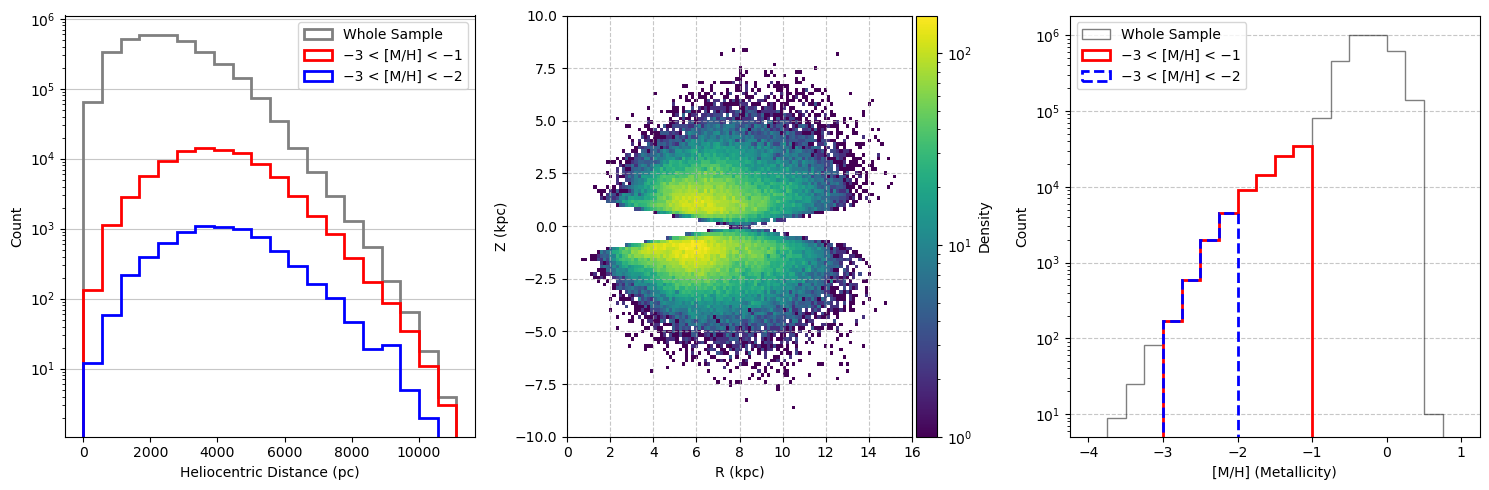

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define bin edges (20 bins from 0 to the maximum value in the distance column)
bin_edges = np.linspace(0, df[distance_col].max(), 21)

# Subset the data based on [M/H] ranges
subset_mh_neg1 = df[(df[mh_col] > -3) & (df[mh_col] < -1)]
subset_mh_neg2 = df[(df[mh_col] > -3) & (df[mh_col] < -2)]

# Define common bins for metallicity histogram
bins = np.arange(-4, 1 + 0.25, 0.25)  # Bins from -4 to 1 with 0.25 step size

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 3 columns, 1 row

# Plot 1: Histogram of Heliocentric Distance
axes[0].hist(
    df[distance_col],
    bins=bin_edges,
    histtype='step',
    color='grey',
    linewidth=2,
    label='Whole Sample'
)
axes[0].hist(
    subset_mh_neg1[distance_col],
    bins=bin_edges,
    histtype='step',
    color='red',
    linewidth=2,
    label='−3 < [M/H] < −1'
)
axes[0].hist(
    subset_mh_neg2[distance_col],
    bins=bin_edges,
    histtype='step',
    color='blue',
    linestyle='-',
    linewidth=2,
    label='−3 < [M/H] < −2'
)
axes[0].set_yscale('log')
axes[0].set_xlabel('Heliocentric Distance (pc)')
axes[0].set_ylabel('Count')
axes[0].legend()
axes[0].grid(axis='y', linestyle='-', alpha=0.7)

# Plot 2: R-Z Distribution
R = df_clean['R']
Z = df_clean['Z']
h = axes[1].hist2d(R, Z, bins=100, norm=LogNorm(), cmap='viridis', cmin=1)
cbar = fig.colorbar(h[3], ax=axes[1], pad=0.01)
cbar.set_label('Density')
axes[1].set_xlabel('R (kpc)')
axes[1].set_ylabel('Z (kpc)')
axes[1].set_xlim(0, 16)
axes[1].set_ylim(-10, 10)
axes[1].grid(True, linestyle='--', alpha=0.7)

# Plot 3: Metallicity Distribution
axes[2].hist(
    df[mh_col], bins=bins, color='grey', alpha=0.5, histtype='step', edgecolor='black',
    label='Whole Sample'
)
axes[2].hist(
    subset_mh_neg1[mh_col], bins=bins, histtype='step', color='red', linestyle='-', linewidth=2,
    label='−3 < [M/H] < −1'
)
axes[2].hist(
    subset_mh_neg2[mh_col], bins=bins, histtype='step', color='blue', linestyle='--', linewidth=2,
    label='−3 < [M/H] < −2'
)
axes[2].set_xlabel('[M/H] (Metallicity)')
axes[2].set_ylabel('Count')
axes[2].legend()
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()


In [10]:
data_array = np.array(
    list(df.itertuples(index=False, name=None)),
    dtype=[(col, df[col].dtype.type) for col in df.columns]
)

hdu = fits.BinTableHDU(data_array)

output_fits_filename = 'filtered_high_quality_sample.fits'
hdu.writeto(output_fits_filename, overwrite=True)

print(f"FITS file saved as '{output_fits_filename}'")

FITS file saved as 'filtered_high_quality_sample.fits'
